In [1]:
import tensorflow as tf
import numpy as np
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary import values as v
from auxiliary.utils import visualizer as vis
from auxiliary.utils.colors import bcolors as bc

from sklearn.metrics import classification_report, confusion_matrix
from cell_division.layers.custom_layers import (
    ExtendedLSEPooling,
    extended_w_cel_loss
)

from cell_division.nets.cam import overlay_heatmap, CAM

# GPU config
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator
)
plt.style.use('default')

import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


increase_gpu_memory()
set_gpu_allocator()


Data

In [2]:
img_dir = v.data_path + 'CellDivision/images_nuclei/'
label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 32

In [3]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

Training

In [4]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss()
)

In [5]:
# model.fit(
#     train_generator,
#     val_generator,
#     epochs=100,
#     verbose=2,
#     batch_size=BATCH_SIZE
# )
# 
# model.model.save('../models/cellular_division_models/vgg16_nuclei_under.h5')

In [6]:
model.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

Testing

In [7]:
results = model.model.evaluate(test_generator, verbose=1)

4/4 [==============================] - 6s 866ms/step - loss: 0.6904 - auc: 0.9435


In [8]:
pred = model.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

                    precision    recall  f1-score   support

Prophase/Metaphase       0.89      0.81      0.85        42
Anaphase/Telophase       0.82      0.86      0.84        42
        Interphase       0.87      0.91      0.89        43

          accuracy                           0.86       127
         macro avg       0.86      0.86      0.86       127
      weighted avg       0.86      0.86      0.86       127



<Figure size 1200x1200 with 0 Axes>

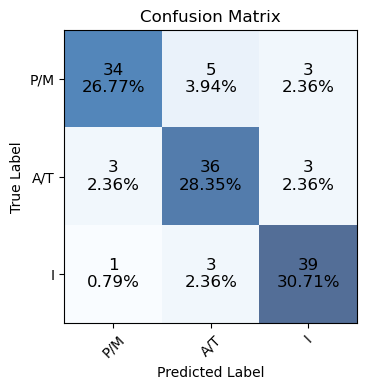

In [9]:
cf_matrix = confusion_matrix(
    test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

Grad-CAM

In [10]:
test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

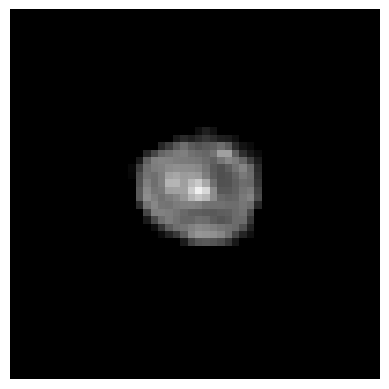

In [11]:
img_idx = 25 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

Real label: Interphase
Predicted label: Interphase


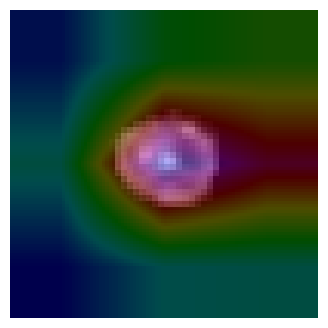

In [12]:
cam = CAM(model.model)
pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

pred_idx = np.argmax(pred)
heatmap = cam.compute_heatmap(test_img_tf, class_idx=pred_idx)

plt.figure(figsize=(4, 4))
plt.imshow(overlay_heatmap(test_img, heatmap, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')
plt.show()

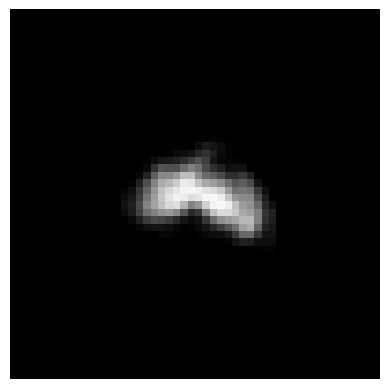

In [13]:
img_idx = 35 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

Real label: Prophase/Metaphase
Predicted label: Prophase/Metaphase


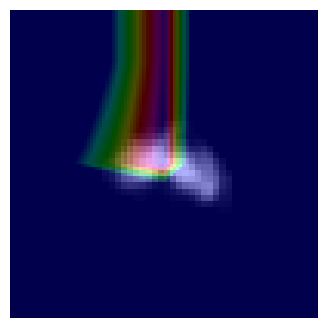

In [14]:
cam = CAM(model.model)
pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

pred_idx = np.argmax(pred)
heatmap = cam.compute_heatmap(test_img_tf, class_idx=pred_idx)

plt.figure(figsize=(4, 4))
plt.imshow(overlay_heatmap(test_img, heatmap, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')
plt.show()

Test calibrarion necessity

1. Negative Log-Likelihood (NLL) Check:

    - NLL measures how well the model’s predicted probability distribution matches the true distribution of labels.
    - If the NLL is much higher than expected, it can indicate that the model is overconfident in its predictions, which often correlates with miscalibration.
    - A low NLL means the model’s probabilistic predictions are aligned with the actual outcomes, suggesting that calibration may not be necessary.

2. Reliability Diagrams and Confidence Histograms:

    - Before applying any calibration, confidence histograms and reliability diagrams help visually inspect miscalibration.
    - A confidence histogram shows the distribution of the model’s confidence in its predictions. If most predictions have high confidence but the accuracy does not match, it signals overconfidence and thus, miscalibration.
    - Reliability diagrams plot accuracy against confidence. A well-calibrated model’s reliability diagram should closely align with the diagonal. Significant deviations from the diagonal indicate the need for calibration.

3. Expected Calibration Error (ECE):

    - The ECE metric provides a more quantitative assessment. High ECE values indicate a significant difference between confidence and accuracy, suggesting that calibration is needed.

In [15]:
from cell_division.calibration_assessment import (
    plot_reliability_diagram,
    plot_calibration_map,
    plot_learned_calibration_map,
    compute_ece,
    compute_multilabel_brier,
    plot_confidence_histogram,
    NLL
)

In [16]:
probs = model.model.predict(val_generator)
labels = val_generator.class2oh(val_generator.img_labels)

Negative Log-Likelihood: 0.44664446006384645


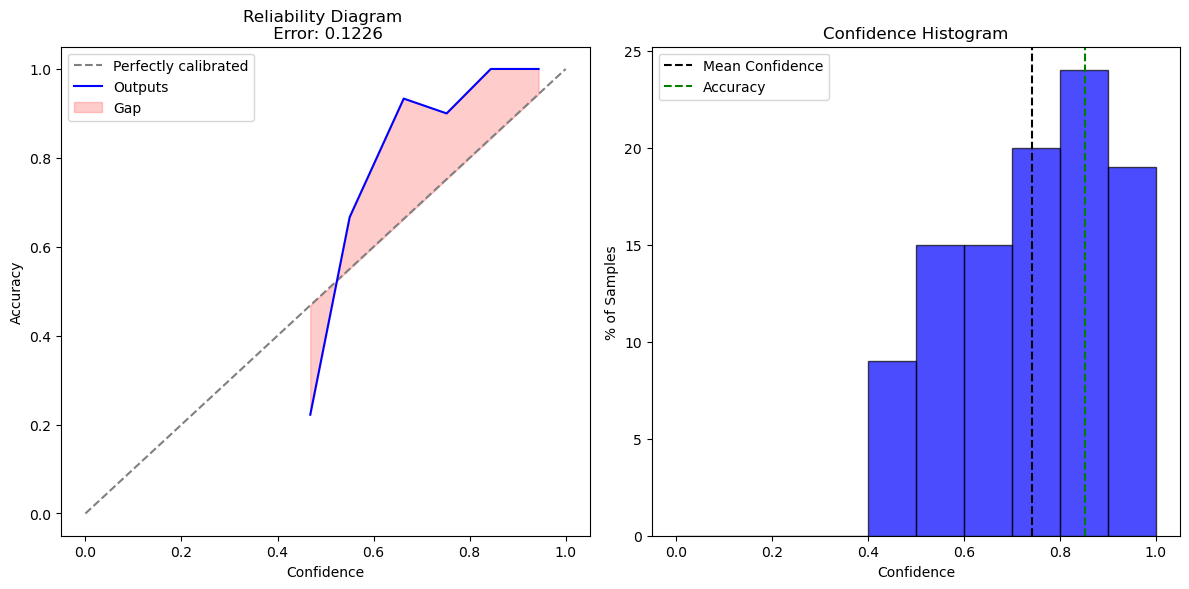

In [17]:
plt.figure(figsize=(12, 6))
plot_reliability_diagram(
    labels, probs, 
    sub_index=1, nrows=1, ncols=2
)
plot_confidence_histogram(
    labels, probs, 
    sub_index=2, nrows=1, ncols=2
)
print(f'{bc.OKBLUE}Negative Log-Likelihood:{bc.ENDC} {NLL(probs, labels)}')

Negative Log-Likelihood: 0.48782312222360374


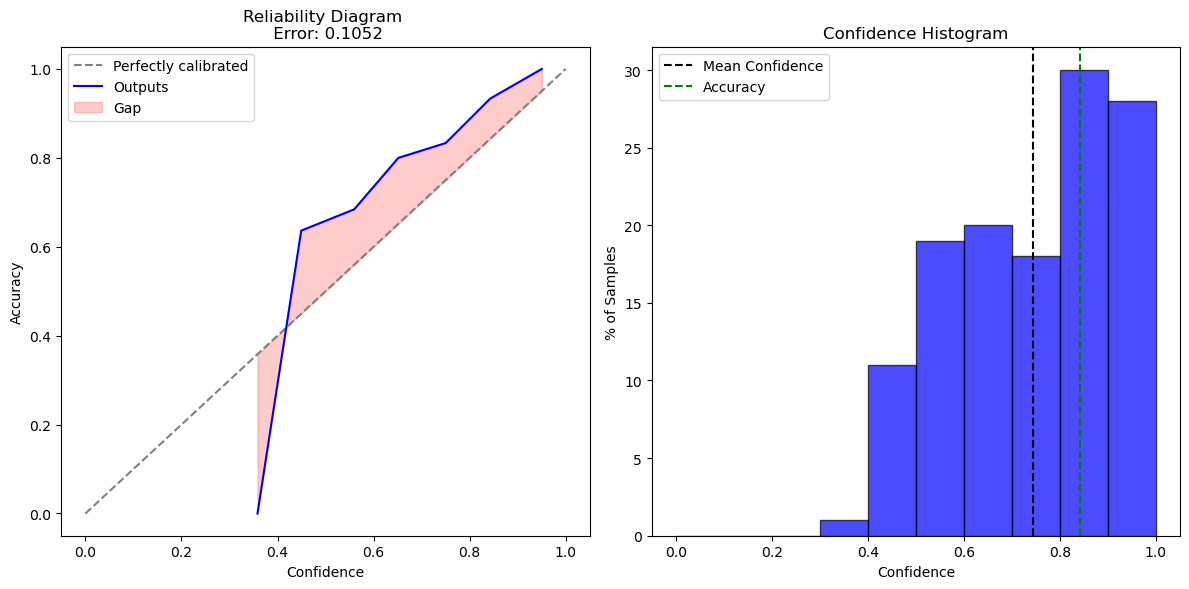

In [18]:
probs = model.model.predict(test_generator)
labels = test_generator.class2oh(test_generator.img_labels)

plt.figure(figsize=(12, 6))
plot_reliability_diagram(
    labels, probs, 
    sub_index=1, nrows=1, ncols=2
)
plot_confidence_histogram(
    labels, probs, 
    sub_index=2, nrows=1, ncols=2
)
print(f'{bc.OKBLUE}Negative Log-Likelihood:{bc.ENDC} {NLL(probs, labels)}')

Model calibration

In [19]:
def print_calibration_results(model, calibrated_model, calibrated_pred, results, generator, method, X_test, y_test):    
    print(f'\t{bc.OKBLUE}Test results:{bc.ENDC}')
    res = calibrated_model.evaluate(generator, verbose=1)
    print(res)
    
    print(f'\t{bc.OKBLUE}Test classification report:{bc.ENDC}')
    print(
        classification_report(
            generator.img_labels, 
            [generator.oh2class(p) for p in calibrated_pred], target_names=generator.CLASS_NAMES, zero_division=0
        )
    )
    
    ece = compute_ece(y_test, calibrated_pred)
    print(f'\t{bc.OKBLUE}Expected Calibration Error:{bc.ENDC} {ece:.4f}')
    
    nll = NLL(calibrated_pred, y_test)
    print(f'\t{bc.OKBLUE}Negative Log-Likelihood:{bc.ENDC} {nll:.4f}')
    
    brier = compute_multilabel_brier(y_test, calibrated_pred)
    print(f'\t{bc.OKBLUE}Multilabel Brier score:{bc.ENDC} {brier:.4f}')
    
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 3, 1)
    
    cf_matrix = confusion_matrix(
        generator.img_labels, 
        [generator.oh2class(p) for p in calibrated_pred]
    )
    vis.plot_confusion_matrix(cf_matrix, sub_index=1, nrows=2, ncols=3)
    
    plot_reliability_diagram(
        y_test, calibrated_pred,
        sub_index=2, nrows=2, ncols=3
    )
    
    plot_confidence_histogram(
        y_test, calibrated_pred,
        sub_index=3, nrows=2, ncols=3
    )
    
    if method != 'none':
        plot_calibration_map(
            model, calibrated_model,
            X_test, generator.img_labels, title='Calibration map',
            sub_index=4, nrows=2, ncols=3
        )
        
        plot_learned_calibration_map(
            calibrated_model,
            'Learned calibration map',
            sub_index=5, nrows=2, ncols=3
        )
    
    plt.show()
    
    results['method'].append(method)
    results['test_results'].append(res)
    results['ece'].append(ece)
    results['brier'].append(brier)
    results['NLL'].append(nll)
    calibrated_model.save(
        f'../models/cellular_division_models/vgg16_nuclei_under_calibrated_{method}.h5'
    )
    
    return results
    
def compute_calibrations(model, X_calib, y_calib, X_test, y_test, methods, generator):
    
    results = {
        'method': [],
        'test_results': [],
        'ece': [],
        'brier': [],
        'NLL': []
    }
    
    for method in methods:
        if method == 'none':
            results = print_calibration_results(
                model.model, model.model, 
                model.model.predict(X_test), results, generator, method,
                X_test, y_test
            )
            continue
        
        model.calibrate(X_calib, y_calib, method=method)
        calibrated_pred = model.calibrated_model.predict(X_test)

        print(model.calibrated_model.summary())

        print(f'{bc.OKGREEN}Calibration method:{bc.ENDC} {method}')
        print(f'\t{bc.OKBLUE}Weights:{bc.ENDC}')
        print(model.calibrated_model.weights[-1])
        
        results = print_calibration_results(
            model.model, model.calibrated_model, 
            calibrated_pred, results, generator, method,
            X_test, y_test
        )
        
    return results        

In [20]:
calibration_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=1,
    resize=INPUT_SHAPE[:2]
)

X_calib, y_calib = calibration_generator.get_all()
print(X_calib.shape, y_calib.shape)

X_test, y_test = val_generator.get_all()
print(X_test.shape, y_test.shape)

(102, 100, 100, 3) (102, 3)
(102, 100, 100, 3) (102, 3)


	Test results:
102/102 [==============================] - 4s 35ms/step - loss: nan - auc: 0.9586
[nan, 0.9586216807365417]
	Test classification report:
                    precision    recall  f1-score   support

Prophase/Metaphase       0.84      0.91      0.87        34
Anaphase/Telophase       0.82      0.79      0.81        34
        Interphase       0.91      0.85      0.88        34

          accuracy                           0.85       102
         macro avg       0.85      0.85      0.85       102
      weighted avg       0.85      0.85      0.85       102

	Expected Calibration Error: 0.1226
	Negative Log-Likelihood: 0.4466
	Multilabel Brier score: 0.0761


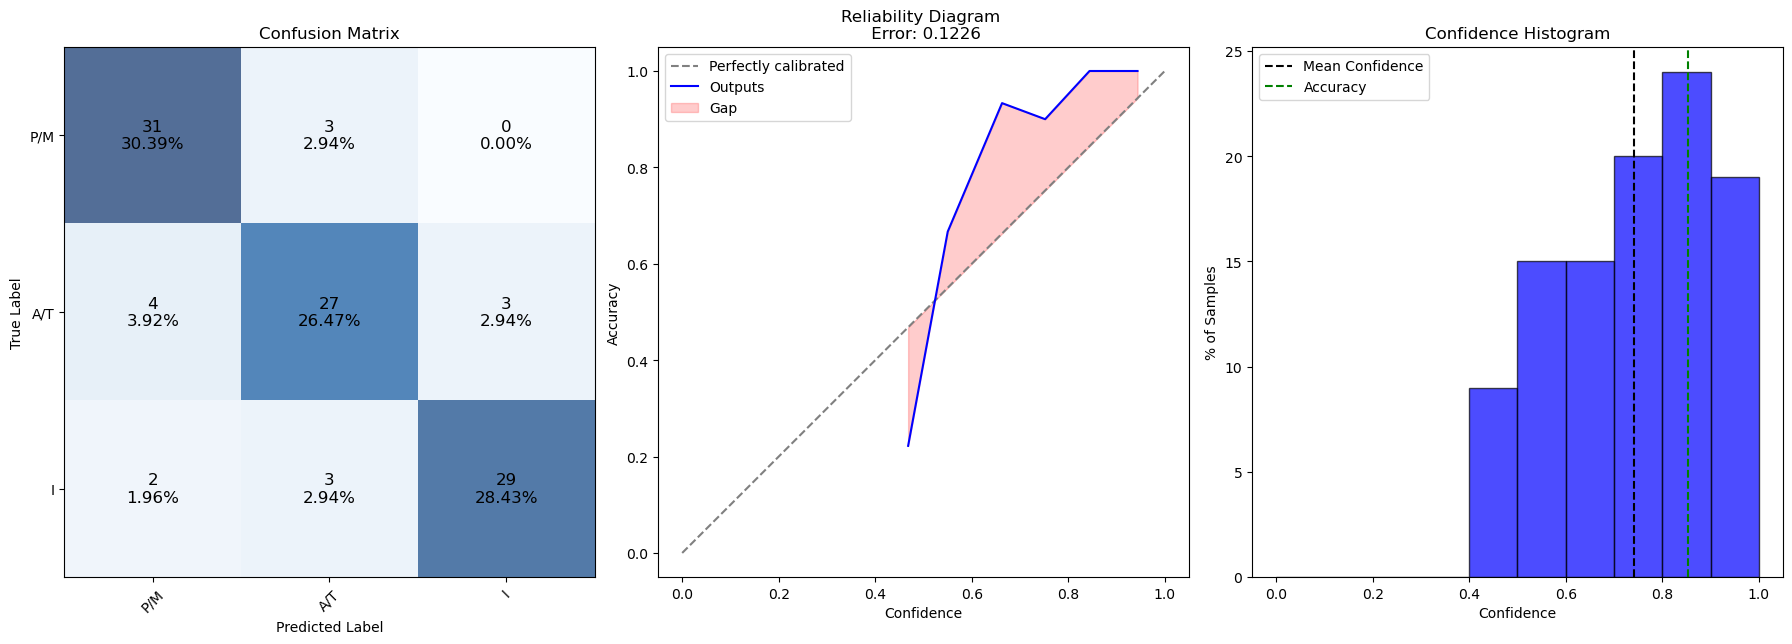

Trainable variables:  1
temperature:0
Epoch 1/100
4/4 [==============================] - 2s 60ms/step - loss: nan - auc: 0.9167 - lr: 0.0500
Epoch 2/100


InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3369298/2939160879.py", line 1, in <module>
      results = compute_calibrations(
    File "/tmp/ipykernel_3369298/3740658080.py", line 87, in compute_calibrations
      model.calibrate(X_calib, y_calib, method=method)
    File "/home/imarcoss/ht_morphogenesis/cell_division/nets/transfer_learning.py", line 256, in calibrate
      self.fit_calibrated_model(X_calib, y_calib)
    File "/home/imarcoss/ht_morphogenesis/cell_division/nets/transfer_learning.py", line 242, in fit_calibrated_model
      self.calibrated_model.fit(
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/metrics.py", line 2347, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3369298/2939160879.py", line 1, in <module>
      results = compute_calibrations(
    File "/tmp/ipykernel_3369298/3740658080.py", line 87, in compute_calibrations
      model.calibrate(X_calib, y_calib, method=method)
    File "/home/imarcoss/ht_morphogenesis/cell_division/nets/transfer_learning.py", line 256, in calibrate
      self.fit_calibrated_model(X_calib, y_calib)
    File "/home/imarcoss/ht_morphogenesis/cell_division/nets/transfer_learning.py", line 242, in fit_calibrated_model
      self.calibrated_model.fit(
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/metrics.py", line 2347, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_6/calibrated_softmax/Softmax:0) = ] [[nan nan nan]...] [y (Cast_4/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_less_equal/Assert/AssertGuard/pivot_f/_13/_41]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_6/calibrated_softmax/Softmax:0) = ] [[nan nan nan]...] [y (Cast_4/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_21394]

In [24]:
results = compute_calibrations(
    model, X_calib, y_calib, X_test, y_test, 
    ['none', 'temperature', 'vector', 'matrix', 'dirichlet'],
    val_generator
)

In [ ]:
import pandas as pd
pd.DataFrame(results)